In [2]:
from qutip import sigmax, sigmay, sigmaz, identity, tensor, basis, expect, krylovsolve, mcsolve
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [5]:
basis(2, 1)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

In [42]:
def pauli(pos, dir, N):
    factors = [identity(2)]*N
    if dir == 'x':
        factors[pos] = sigmax()
    elif dir == 'y':
        factors[pos] = sigmay()
    elif dir == 'z':
        factors[pos] = sigmaz()
    return tensor(factors)

def on_site_detuning(pos, N):
    sum = 0
    for j in range(N):
        if np.abs(pos - j) == 1:
            sum += V_nn
        elif np.abs(pos - j) == 2:
            sum += V_nnn

    return -0.5* sum

def interaction_strength(pos1, pos2):
    if np.abs(pos1 - pos2) == 1:
        return V_nn
    if np.abs(pos1 - pos2) == 2:
        return V_nnn
    else:
        return 0

In [43]:
def hamiltonian(N, rabi_f, delta, V_nn, V_nnn):
    H = 0.5 * rabi_f * sum([pauli(i, 'x', N) for i in range(N)])
    H -= 0.5 * sum([(delta + on_site_detuning(i, N)) * pauli(i, 'z', N) for i in range(N)])

    interaction_term = sum([sum([interaction_strength(i, j) * pauli(i, 'z', N) * pauli(j, 'z', N) for j in range(N)]) for i in range(N)])
    H += 0.125 * interaction_term
    return H

In [6]:
rabi_f = 2*np.pi*6.4*(10**6) # rabi frequency for Rydberg to ground state cycles (Hz)
V_nn = 2*np.pi*60*(10**6) # nearest neighbors interaction strength (Hz) (ref page 180, strongly interacting pairs)
V_nnn = 2*np.pi*2.3*(10**6) # next nearest neighbors interaction strength (Hz)
N = 3

psi0 = tensor([basis(2, 1)] * N)
tlist = np.linspace(0.0, 475*(10**-9), 200)
probs = np.abs(krylovsolve(hamiltonian(N, rabi_f, 0, V_nn, V_nnn), psi0, tlist, krylov_dim=min(2**N, 40)).states)**2

TypeError: krylovsolve currently supports Hamiltonian Qobj operators only

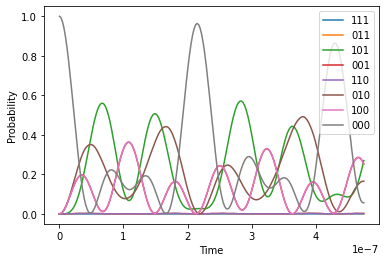

In [45]:
plt.figure()
for s in range(8):
   plt.plot(tlist, probs[:, s])
plt.legend(('111', '011', '101', '001', '110', '010', '100', '000'))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.show()

In [46]:
rabi_f = 2*np.pi*6.4*(10**6) # rabi frequency for Rydberg to ground state cycles (Hz)
V_nn = 2*np.pi*60*(10**6) # nearest neighbors interaction strength (Hz) (ref page 180, strongly interacting pairs)
V_nnn = 2*np.pi*2.3*(10**6) # next nearest neighbors interaction strength (Hz)
N = 5
psi0 = tensor([basis(2, 1)] * N)
expect_z = [krylovsolve(hamiltonian(N, rabi_f, 0, V_nn, V_nnn), psi0, tlist, krylov_dim=min(2**N, 40), e_ops=[pauli(i, 'z', N)]).expect[0] for i in range(N)]

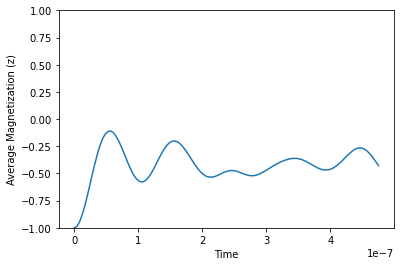

In [47]:
plt.figure()
plt.plot(tlist, np.mean(expect_z, axis=0))
plt.xlabel('Time')
plt.ylabel('Average Magnetization (z)')
plt.ylim(-1, 1)
plt.show()

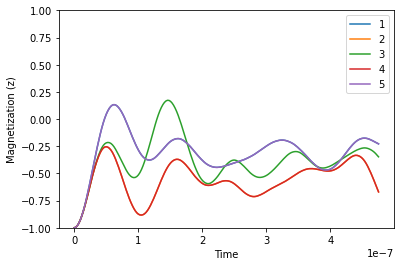

In [48]:
plt.figure()
for s in range(N):
   plt.plot(tlist, expect_z[s])
plt.legend([i+1 for i in range(N)])
plt.xlabel('Time')
plt.ylabel('Magnetization (z)')
plt.ylim(-1, 1)
plt.show()

In [49]:
rabi_f = 2*np.pi*0.9*(10**6) # rabi frequency for Rydberg to ground state cycles (Hz)
delta = 2*np.pi*2.2*(10**6)
V_nn = 2*np.pi*60*(10**6) # nearest neighbors interaction strength (Hz) (ref page 180, strongly interacting pairs)
V_nnn = 2*np.pi*2.3*(10**6) # next nearest neighbors interaction strength (Hz)
N = 10
psi0 = tensor([basis(2, 1)] * N)
tlist = np.linspace(0.0, 2*(10**-6), 200)

data = []

for d in range(N):
    avg = np.zeros(len(tlist))
    for i in range(N-d):
        result = krylovsolve(hamiltonian(N, rabi_f, delta, V_nn, V_nnn), psi0, tlist, krylov_dim=min(2**N, 40), e_ops=[pauli(i, 'z', N), pauli(i+d, 'z', N), pauli(i, 'z', N)*pauli(i+d, 'z', N)])
        avg += result.expect[2] - result.expect[0]*result.expect[1]
    avg /= (N-d)
    data.append(0.25 * avg)

data = np.transpose(data)

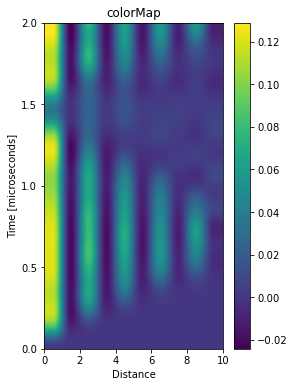

In [50]:
fig = plt.figure(figsize=(4, 6))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(data, origin='lower', extent=[0, N, 0, 2])
ax.set_aspect('auto')

ax.set_yticks(np.linspace(0, 2, 5))

plt.xlabel("Distance")
plt.ylabel("Time [microseconds]")
plt.colorbar(orientation='vertical')
plt.show()